# Simulating the 100 Prisoners Riddle

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/100_prisoners_problem_qtl1.svg/1920px-100_prisoners_problem_qtl1.svg.png" alt="Girl in a jacket" width="400" height="300">

The director of a prison offers 100 prisoners, who are numbered from 1 to 100, a chance at freedom.
- A room contains a cupboard with 100 drawers (or boxes).
- The director randomly puts one prisoner's number in each closed drawer (or box).
- The prisoners enter the room, one after another. Each prisoner may open and look into 50 drawers in any order.
- The drawers are closed again afterwards. 

To Succeed:
1. Every prisoner finds their number in one of the drawers, all prisoners are pardoned.
2. If just one prisoner does not find their number, all prisoners lose.

Before the first prisoner enters the room, the prisoners may discuss strategy — but may not communicate once the first prisoner enters to look in the drawers. What is the prisoners' best strategy?

In [1]:
import pandas as pd
import numpy as np
from tqdm import trange

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")
color_pal = sns.color_palette(n_colors=50)

%load_ext lab_black

In [33]:
def shuffle_boxes():
    prisoner_numbers = [x for x in range(0, 100)]
    boxes = {}
    np.random.shuffle(prisoner_numbers)
    for i, p in enumerate(prisoner_numbers):
        boxes[i] = p
    return boxes


PRISONERS = [x for x in range(0, 100)]
BOX_NUMBERS = [x for x in range(0, 100)]

# Random Choice Strategy

In [48]:
def random_strategy(prisoner_number, boxes):
    """
    Randomly select 50 boxes for the prisoner.

    Returns True if they found their number, False if they did not
    """
    prisoner_choices = np.random.choice(BOX_NUMBERS, size=50, replace=False)
    if prisoner_number in prisoner_choices:
        return True
    return False

In [169]:
def try_strategy(boxes, strategy):
    n_correct = 0
    for prisoner in PRISONERS:
        correct = strategy(prisoner_number=prisoner, boxes=boxes)
        if correct:
            n_correct += 1
    return n_correct

In [114]:
results = {}
num_sim = 5_000
for sim in trange(num_sim):
    boxes = shuffle_boxes()
    n_correct = try_strategy(boxes, random_strategy)
    results[sim] = n_correct

100%|███████████████████████████████████████████████████████████████████████| 5000/5000 [00:15<00:00, 319.17it/s]


In [122]:
results_random = pd.DataFrame.from_dict(results, orient="index", columns=["ncorrect"])
results_random["ncorrect"].mean(), results_random["ncorrect"].std()

(50.0332, 4.9089833350172105)

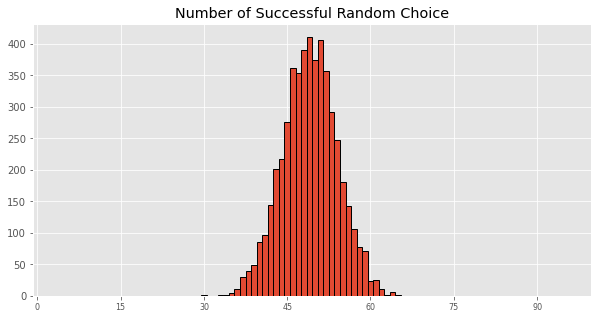

In [132]:
results_agg = pd.DataFrame(index=range(1, 101))
results_agg["count"] = results_agg.index.map(
    results_random["ncorrect"].value_counts().to_dict()
).fillna(0)

ax = results_agg.plot(
    kind="bar",
    figsize=(10, 5),
    width=1,
    lw=1,
    edgecolor="black",
    title="Number of Successful Random Choice",
)

ax.set_xticklabels(ax.get_xticks(), rotation=0, size=8)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
ax.legend().remove()

plt.show()

In [133]:
0.5**100

7.888609052210118e-31

In [134]:
0.00000000000000000000000000000078

7.8e-31

# Loop Strategy
- Start with the box that's their own number
- Select the next box based on the number in the last chosen box

In [164]:
def loop_strategy(prisoner_number, boxes):
    """
    Select 50 boxes starting with their own number,
    next selecting the results from the last box and so on.

    Returns True if they found their number, False if they did not
    """
    next_box = prisoner_number
    for x in range(50):
        if boxes[next_box] == prisoner_number:
            return True
        next_box = boxes[next_box]
    return False

In [170]:
results = {}
num_sim = 5_000
for sim in trange(num_sim):
    boxes = shuffle_boxes()
    n_correct = try_strategy(boxes, loop_strategy)
    results[sim] = n_correct
results_loop = pd.DataFrame.from_dict(results, orient="index", columns=["ncorrect"])
results_loop["ncorrect"].mean(), results_loop["ncorrect"].std()

100%|██████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2546.78it/s]


(49.5866, 35.73341119701777)

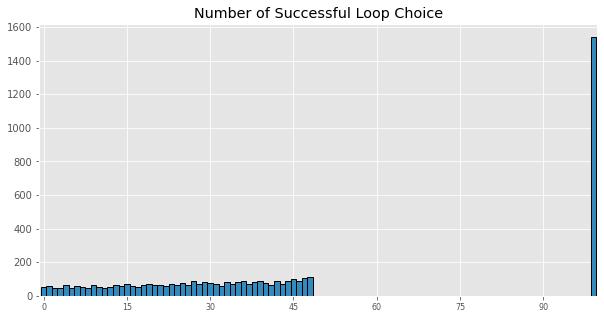

In [171]:
results_agg = pd.DataFrame(index=range(1, 101))

results_agg["counts"] = results_agg.index.map(
    results_loop["ncorrect"].value_counts().to_dict()
).fillna(0)

ax = results_agg.plot(
    kind="bar",
    color=color_pal[1],
    figsize=(10, 5),
    width=1,
    lw=1,
    edgecolor="black",
    title="Number of Successful Loop Choice",
)

ax.set_xticklabels(ax.get_xticks(), rotation=0, size=8)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
ax.legend().remove()

plt.show()

In [175]:
(results_loop["ncorrect"] == 100).mean()

0.3082

# How Does it work?
- Boxes are "linked" to each other.
- You can think of this in terms of a graph network where the boxes are nodes and the paper is an edge.
- The graph consists of any number of "loops".
- By starting with their own number the prisoner is guaranteed to be in their own loop.
- If the largest "loop" within the graph is less than 50, all prisoners will succeed!

In [182]:
boxes = shuffle_boxes()
G = nx.DiGraph()
G.add_nodes_from(BOX_NUMBERS)

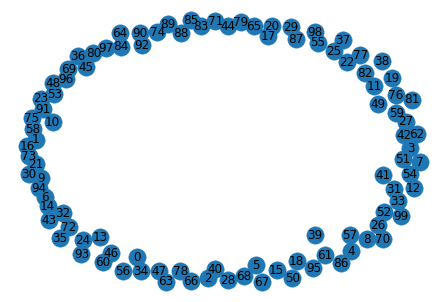

In [183]:
nx.draw(G, with_labels=True)
plt.show()

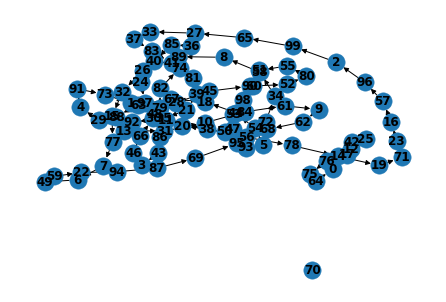

In [184]:
edges = [(x, y) for x, y in boxes.items()]
G.add_edges_from(edges, weight=1)
nx.draw(G, with_labels=True, font_weight="bold")

# Color The Loops

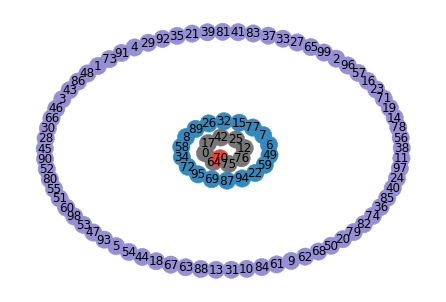

In [188]:
node_loop = {}
loops = nx.simple_cycles(G)

for loop, nodes in enumerate(loops):
    for node in nodes:
        node_loop[node] = loop
loop_df = pd.DataFrame.from_dict(node_loop, orient="index", columns=["loop"])

loop_df["color"] = loop_df["loop"].apply(lambda x: color_pal[x])
loop_df = loop_df.sort_index()

# pos = None
# pos = nx.layout.fruchterman_reingold_layout(G)
pos = nx.layout.kamada_kawai_layout(G)

nx.draw(G, pos, node_color=loop_df["color"].values, with_labels=True)
plt.show()

In [189]:
# Add colors to node
loops = nx.simple_cycles(G)
for node, loop in loop_df["loop"].to_dict().items():
    G.nodes[node]["loop"] = str(loop)
    G.nodes[node]["label"] = node

# Function to Create this Graph

In [191]:
def create_graph(boxes):
    G = nx.DiGraph()
    G.add_nodes_from(BOX_NUMBERS)
    edges = [(x, y) for x, y in boxes.items()]
    G.add_edges_from(edges, weight=1)
    node_loop = {}
    loops = nx.simple_cycles(G)

    for loop, nodes in enumerate(loops):
        for node in nodes:
            node_loop[node] = loop
    loop_df = pd.DataFrame.from_dict(node_loop, orient="index", columns=["loop"])

    loop_df["color"] = loop_df["loop"].apply(lambda x: color_pal[x])
    loop_df = loop_df.sort_index()
    # Add colors to node
    for node, loop in loop_df["loop"].to_dict().items():
        G.nodes[node]["group"] = str(loop)
        G.nodes[node]["loop_key"] = loop
        G.nodes[node]["label"] = str(node)
    return G, loop_df

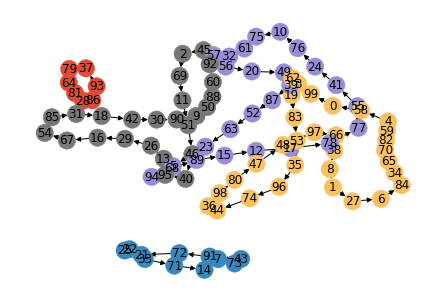

In [196]:
boxes = shuffle_boxes()
G, loop_df = create_graph(boxes)
nx.draw(G, with_labels=True, node_color=loop_df["color"].values)

In [202]:
max_loop_size = loop_df["loop"].value_counts().max()
max_loop_size

31

# Interactive Graph

In [204]:
from pyvis.network import Network

boxes = shuffle_boxes()
G, loop_df = create_graph(boxes)

net = Network(notebook=True, height=300, width=800, directed=True)
net.from_nx(G, default_node_size=10)
net.show("example.html")

In [216]:
boxes = shuffle_boxes()
G, loop_df = create_graph(boxes)

longest_loop = loop_df["loop"].value_counts().max()
npassed_random = try_strategy(boxes, random_strategy)
npassed_loop = try_strategy(boxes, loop_strategy)

print(f"Longest Loop {longest_loop}")
print(f"Random: {npassed_random}")
print(f"Loop: {npassed_loop}")

net = Network(notebook=True, height=500, width=1000, directed=True)
net.from_nx(G, default_node_size=10)
net.show("example.html")

Longest Loop 40
Random: 47
Loop: 100


# Simulate the Longest Loop

In [221]:
longest_loops = []
for x in trange(10_000):
    boxes = shuffle_boxes()
    G, loop_df = create_graph(boxes)
    longest_loop = loop_df["loop"].value_counts().max()
    longest_loops.append(longest_loop)

100%|█████████████████████████████████████████████████████████████████████| 10000/10000 [00:54<00:00, 184.04it/s]


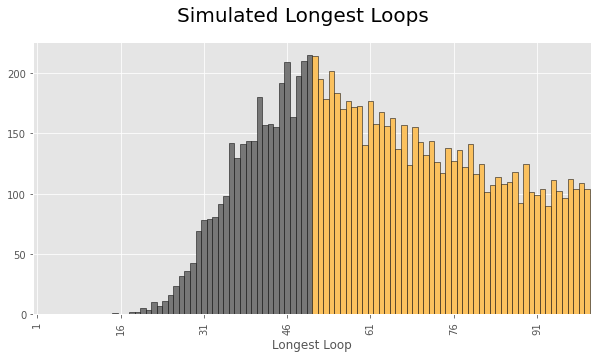

In [222]:
longest_loop_df = pd.DataFrame(index=range(1, 101))
longest_loop_df["count"] = longest_loop_df.index.map(
    pd.Series(longest_loops).value_counts().to_dict()
).fillna(0)

fig, ax = plt.subplots(figsize=(10, 5))

success = longest_loop_df.copy()
success.loc[success.index > 50, "count"] = 0
success.plot(kind="bar", color=color_pal[3], width=1, edgecolor="black", ax=ax)

fail = longest_loop_df.copy()
fail.loc[fail.index <= 50, "count"] = 0
fail.plot(kind="bar", color=color_pal[4], width=1, edgecolor="black", ax=ax)

plt.xlabel("Longest Loop")
fig.suptitle("Simulated Longest Loops", fontsize=20)

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.legend().remove()
plt.show()